
# La numérisation et ses effets

<div class="alert alert-block alert-warning">
<b>Important:</b> Pour avancer d'étape en étape, il suffit de cliquer sur la petite flèche "play" pour lancer le tracé codé dans une case.
</div>



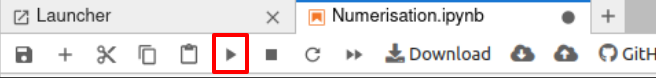

<div class="alert alert-block alert-info">
Il n'est pas nécessaire de lire les blocs de code.
</div>


In [1]:
#On installe et importe les bibliothèques nécessaires
%pip install ipympl pydub scipy

%matplotlib ipympl
from ipywidgets import interactive,interact
import IPython.display as ipd
import matplotlib.pyplot as plt
from matplotlib.widgets import LassoSelector
from matplotlib.path import Path
import numpy as np
import locale
from pydub import AudioSegment
from scipy.fft import fft, fftfreq, fftshift
import warnings
warnings.filterwarnings('ignore')
print("Bibliothèques importées avec succès")

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Bibliothèques importées avec succès


## Pré-requis

<div class="alert alert-block alert-info">
Bref rappel concernant la Transformée de Fourier (TF) :
</div>

Concrètement, pour une suite finie de complexes $u_n$, où $0\leq n < N$, la TF de $u_n$ possède également $N$ termes, le terme $k$ de sa TF étant le produit scalaire de $u_n$ avec le vecteur $e^{2i\pi\frac{k}{N}}$ , où $0\leq k < N$. 

Les $e^{2i\pi\frac{k}{N}}$, où $0\leq k < N$, forment une base de cet ensemble, tout se passe comme si on projetait $u_n$ sur cette base.

Cela donne donc : $\mathrm{TF}[u_n] = U(k) = \sum_{n=0}^{N-1}u_n \mathrm e^{-2\mathrm i \pi k \frac nN} \qquad \text{pour} \qquad  0 \leq k < N$

Ou, si tu préfères : $\mathrm{TF}[u_n] = U(k) = \sum_{n=0}^{N-1}u_n \left[ \mathrm {cos}\left(-2\mathrm i \pi k \frac nN\right) + i \mathrm {sin}\left(-2\mathrm i \pi k \frac nN\right)\right] \qquad \text{pour} \qquad  0 \leq k < N$

***

On peut visualiser en compilant ci-dessous la TF de certains signaux usuels, pour travailler son intuition :


In [2]:
plt.rcParams.update({'font.size': 15})
#locale.setlocale(locale.LC_ALL, '')
plt.rcParams['axes.formatter.use_locale'] = False



list_types=['sinus','créneau','impulsion dirac périodique', 'impulsion dirac seule']

def makesignal(typ,freq,ampl,time):
    if typ=='sinus':
        return(ampl*np.sin(2*np.pi*freq*time))
    elif typ=='créneau':
        return(ampl*np.sign(np.sin(2*np.pi*freq*time)))
    elif typ=='impulsion dirac périodique':
        sign=np.zeros(np.shape(time))
        indexdirac=[]
        for k in range(len(time)):
            if time[k]*freq > len(indexdirac): #dès qu'on passe une période d'échantillonnage, on récupère un dirac
                indexdirac.append(k)
                #break
        for makedir in indexdirac :
            sign[makedir]=ampl
        return(sign)
    elif typ == 'impulsion dirac seule':
        sign=np.zeros(np.shape(time))
        sign[1]= ampl#*len(time)/(2*np.pi)
        return(sign)
    else :
        return(np.zeros(np.shape(time)))


def f(type_signal1, amplitude1,frequence1,type_signal2, amplitude2,frequence2):
    
    fig, axs = plt.subplots(nrows=1, ncols=2,figsize=(12,6))

    xnewsin = np.linspace(0, 1, 30000)  #le temps sera une homothétie de x 
    signal1=makesignal(type_signal1,frequence1,amplitude1,xnewsin)
    signal2=makesignal(type_signal2,frequence2,amplitude2,xnewsin)
    
    signaltot = signal1+signal2
    
    
    axs[0].tick_params(axis='both', which='major', labelsize=20)
    axs[0].tick_params(axis='both', which='minor', labelsize=20)
    
    axs[0].grid(which='major', color='#DDDDDD', linewidth=2)
    axs[0].grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=1)
    axs[0].minorticks_on()
    axs[0].set_axisbelow(True) 


    
    axs[0].plot( xnewsin[:400]*1e3,signaltot[:400], label='Signal créé')
       
    axs[0].legend(loc = 'upper right',fontsize=20)
    axs[0].set_ylabel("Amplitude (U.A.)",fontsize=20)
    axs[0].set_xlabel("Temps (ms)")
    axs[0].set_title("Enregistrement")

 #-------------------------------------------------------------------------------
    #le spectre :

    #nbTsin = 200 #pour avoir un joli spectre, on le fait sur 200x ce qu'on affiche à gauche.
    TFmashupsin=[(xnewsin[i],signaltot[i]) for i in range(len(xnewsin))]
    #coordfouriersin = [(TFmashupsin[k%len(TFmashupsin)][0]+(k//len(TFmashupsin))*TFmashupsin[-1][0],TFmashupsin[k%len(TFmashupsin)][1]) for k in range(nbTsin *len(TFmashupsin))]
    pointssin = TFmashupsin#coordfouriersin
    
    
    Tsin = xnewsin[-1]/(len(xnewsin))  #Durée entre deux échantillons successifs, utile pour avoir une échelle de fréquence sur la TF

    
    xsin = np.array([xh for xh, _ in pointssin])
    ysin = np.array([yh for _, yh in pointssin])
    yfsin = fft(ysin)#on calcule la tf
    xfsin = fftfreq(len(pointssin), Tsin) #on obtient une échelle de fréquences en abscisse
    xfsin = fftshift(xfsin)
    yplotsin = fftshift(yfsin)#on centre cette tf
    axs[1].plot(xfsin, 1.0 / len(pointssin) * np.abs(yplotsin),alpha=1,label="spectre signal initial")#et on la trace
    axs[1].set_xlim([-5,3500])#on ne plot pas trop loin pour une meilleure visibilité
    #axs[1].set_ylim(bottom=-0.05)

    axs[1].set_ylabel("Amplitude (U.A.)")
    axs[1].set_xlabel("Fréquence (Hz)")
    #axs[0, 0].set_title("Enregistrement d'une onde sonore de fréquence f = {} Hz".format(round(freq,1)))
    axs[1].set_title("Spectre")
    #itx = np.fft.ifft(tx);
    axs[1].grid(which='major', color='#DDDDDD', linewidth=3)

    axs[1].grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=1.5)

    axs[1].minorticks_on()

    plt.legend(loc = 'upper right')
    plt.show()

    return 

#actualisation de la barre d'actualisation dynamique
interactive_plot = interact(f, type_signal1=list_types, amplitude1=(-5, 5,1),frequence1=(100, 2000,100),type_signal2=list_types,amplitude2=(-5, 5,1),frequence2=(100, 2000,100))

interactive(children=(Dropdown(description='type_signal1', options=('sinus', 'créneau', 'impulsion dirac pério…

Ce petit script fait donc la somme de deux signaux, affiche cette somme et sa TF.

***
## I- Numériser un signal

Pour convertir un signal analogique (continu) en un signal numérique (discret, quantifié), il faut **discrétiser** le signal analogique **en temps** et **en amplitude**. Au fond, on veut approximer un signal contenant une infinité d'information par des 0 et des 1.


### I.1- Discrétisation temporelle d'un signal
Pour la discrétisation en temps, on parle d'échantillonnage : 

<div class="alert alert-block alert-info">
<b>Définition :</b>
L'échantillonnage consiste à ne conserver que certains points du signal analogique, prélevés périodiquement. 
</div>

Si on zoomait à l'infini sur un signal d'une seconde, on pourrait enregistrer une infinité de points, pour éviter cela on enregistre les échantillons à intervalle de temps constant, intervalle qu'on appelle la **période d'échantillonnage** $T_e$. 

> **Remarque** : On appelle l'intervalle entre deux échantillons la **période d'échantillonnage** $T_e$, on parle aussi de **fréquence d'échantillonnage** $f_e$, avec bien sûr $f_e = \frac{1}{T_e}$.


Commençons par la discrétisation temporelle, l'échantillonnage. En compilant le bloc suivant, tu pourras faire varier la fréquence d'échantillonnage du graphique. 



In [3]:
plt.rcParams.update({'font.size': 18})
#locale.setlocale(locale.LC_ALL, '')
#plt.rcParams['axes.formatter.use_locale'] = True


Tmin = 0#temps de début de plot
Tmax = 0.02#temps de fin de plot
points = 1000
freq = 100#fréquence de la sinusoïde


def sample2(signal,temps,f_ech,bit_qt):
  signal_max = np.max(signal)
  signal_min = np.min(signal)
  step = (signal_max-signal_min)/(2**bit_qt)#pas de quantification

  numb_avg_points = np.ceil((len(temps)/(temps[-1]-temps[0]))*1/f_ech) #nb de pts à échantillonner
  avg = [signal[0]]
  signech = []
  lastavg = 0
  for index in range(1,len(signal)):
    avg.append(signal[index]) #On moyenne sur chaque période d'échantillonnage.
    if len(avg) < numb_avg_points :
      pass
    else :
      lastavg = avg[0]
      for i in range(len(avg)):
        signech.append(lastavg) #on enregistre la valeur échantillonnée
      avg = []

  lastavg = np.mean(avg)
  for i in range(len(avg)):
        signech.append(lastavg)

  #signal_sample = [((point-signal_min)//step)*step+step/2+signal_min for point in signech]  #fais gaffe, il faudra faire la quantification après pour pas les perdre
  signal_sample = signech
  return(signal_sample) #et on renvoie le résultat


def f(f_echantillonnage):

    fig, axs = plt.subplots(nrows=2, ncols=1,figsize=(10,5))
    bit_qt = 64#quantification "infinie" sur ce premier exemple qui ne parle que d'échantillonnage

    x = np.linspace(Tmin, Tmax,points)
    signal = np.sin(2*np.pi*x*freq)#le signal est un sinus

    axs[0].plot(x*1000, signal ,color = 'black',linewidth = 2,linestyle = "dashed",alpha = 0.5,label = "signal initial")

    signalech = sample2(signal,x,f_echantillonnage,bit_qt) #le même, mais échantillonné

    tech = np.linspace(Tmin,Tmax,int((Tmax-Tmin)*f_echantillonnage)+1) #pb avec le step ici -> asservi au fenêtrage temporel
    axs[0].scatter(tech*1000, np.sin(2*np.pi*tech*freq) ,color = 'red',linewidth = 2,label = "échantillonnage")

    axs[0].set_ylabel("Amplitude (V)")
    axs[0].set_xlabel("Temps (ms)")#on légende le graphique
    axs[0].legend(loc="upper right")




    axs[1].plot(x*1000, signal ,color = 'black',linewidth = 2,linestyle = "dashed",alpha = 0.5,label = "signal initial")


    axs[1].scatter(tech*1000, np.sin(2*np.pi*tech*freq) ,color = 'red',linewidth = 2)

    minloc,maxloc=(np.min(signal),np.max(signal))
    for line in range(len(tech)-1):#on trace les lignes verticales marquant les événements d'échantillonnage
      axs[0].plot((tech[line]*1000,tech[line]*1000),(minloc,maxloc),color = 'black',linewidth = 1,linestyle="dashed",alpha = 0.5)

      if line ==0 :
        axs[1].plot((tech[line]*1000,tech[line]*1000+1000/f_echantillonnage),(np.sin(2*np.pi*tech[line]*freq),np.sin(2*np.pi*tech[line]*freq)),color = 'red',linewidth = 2,label="signal échantillonné")
      else :
        axs[1].plot((tech[line]*1000,tech[line]*1000+1000/f_echantillonnage),(np.sin(2*np.pi*tech[line]*freq),np.sin(2*np.pi*tech[line]*freq)),color = 'red',linewidth = 2)
        axs[1].plot((tech[line]*1000,tech[line]*1000),(np.sin(2*np.pi*tech[line-1]*freq),np.sin(2*np.pi*tech[line]*freq)),color = 'red',linewidth = 2)


    axs[1].set_ylabel("Amplitude (V)")
    axs[1].set_xlabel("Temps (ms)")
    axs[0].set_title("Fréquence d'échantillonnage : {} Hz".format(f_echantillonnage))

    axs[1].legend(loc="upper right")
    plt.show()


interactive_plot = interactive(f, f_echantillonnage=(100, 2000,100))
output = interactive_plot.children[-1]
output.layout.height = '700px'
interactive_plot



interactive(children=(IntSlider(value=1000, description='f_echantillonnage', max=2000, min=100, step=100), Out…



### I.2- Discrétisation en amplitude d'un signal

Enfin, toutes ces valeurs échantillonnées sont en nombre fini, certes, mais ont potentiellement un nombre infini de décimales. Or, n'importe quelle valeur ayant un nombre infini de décimales prendrais toujours un espace de stockage infini. On restreint donc les valeurs que peut prendre un signal à un nombre fini de paliers possibles.

<div class="alert alert-block alert-info">
<b>Définition :</b> La quantification consiste à limiter les valeurs d'amplitude que peut prendre un signal à un nombre fini de paliers.
</div>

Par exemple, si on code la valeur d'un échantillon sur 3 bits, il y aura donc $2^{3}=8$ paliers possibles (000 001 010 011 100 101 110 111). "Arrondir" les valeurs échantillonnées pour les stocker, c'est ce qu'on appelle la quantification.

> **Remarque** : Si un signal est encodé sur $N$ bits, alors le nombre de paliers de valeur accessibles est $2^N$.



On déduit de ces infos que pour stocker cette information il faudra $3f_e$ bits par seconde de fichier à enregistrer.




Sur le graphique ci-dessous, tu peux modifier à la fois la fréquence d'échantillonnage $f_e$ et le nombre de bits de quantification $N$.

In [8]:
#voir les commentaires de la cellule précédente
Tmin = 0
Tmax = 0.02
points = 1000
freq = 100


def sample(signal,temps,f_ech,bit_qt): #échantillonne et quantifie un signal analogique
  signal_max = np.max(signal)
  signal_min = np.min(signal)
  step = (signal_max-signal_min)/(2**bit_qt)

  numb_avg_points = np.ceil((len(temps)/(temps[-1]-temps[0]))*1/f_ech)
  avg = [signal[0]]
  signech = []
  lastavg = 0
  for index in range(1,len(signal)):
    avg.append(signal[index])
    if len(avg) < numb_avg_points :
      pass
    else :
      lastavg = np.mean(avg)
      for i in range(len(avg)):
        signech.append(lastavg)
      avg = []

  lastavg = np.mean(avg)
  for i in range(len(avg)):
        signech.append(lastavg)

  signal_sample = [((point-signal_min)//step)*step+step/2+signal_min for point in signech]  #fais gaffe, il faudra faire la quantification après l'échantillonnage normalement
  #attention c'est une qtfication centrée

  return(signal_sample)


def f(freq_ech,bit_qt):


    fig,ax = plt.subplots(figsize=(10,5))



    x = np.linspace(Tmin, Tmax,points)
    signal = np.sin(2*np.pi*x*freq)

    ax.plot(x*1000, signal ,color = 'black',linewidth = 2,linestyle = "dashed",alpha = 0.5)#on trace le signal analogique

    signalech = sample(signal,x,freq_ech,bit_qt)

    ax.plot(x*1000, signalech ,color = 'black',linewidth = 2)#on trace le signal numérique

    ax.set_ylabel("Amplitude (V)")
    ax.set_xlabel("Temps (ms)")#on légende à nouveau
    ax.set_title("Quantification")



    minx,maxx = (np.min(x)*1000,np.max(x)*1000)
    (sign_min,sign_max) = (np.min(signal),np.max(signal))
    steploc = (sign_max-sign_min)/(2**bit_qt)
    ax.plot((minx,maxx),(sign_min+steploc/2,sign_min+steploc/2),color = 'black',linewidth = 1,linestyle="dashed",alpha = 0.05+np.max(((0.5-(2**bit_qt)/256),0)),label = "niveaux de quantification")
    
    #on trace les palliers de quantification
    for quantiline in range(1,2**bit_qt):
        ax.plot((minx,maxx),(sign_min+steploc*quantiline+steploc/2,sign_min+steploc*quantiline+steploc/2),color = 'black',linewidth = 1,linestyle="dashed",alpha = 0.05+np.max(((0.5-(2**bit_qt)/256),0)))

    
    ax.legend(loc = 'upper right')

    plt.show()


interactive_plot = interactive(f, freq_ech=(100, 20000,100),bit_qt=(1,8,1)) #tracer un signal échantillonné de fréquence et de nb de bits de
#quantification variable
output = interactive_plot.children[-1]
output.layout.height = '700px'
interactive_plot




interactive(children=(IntSlider(value=10000, description='freq_ech', max=20000, min=100, step=100), IntSlider(…

<div class="alert alert-block alert-success">
<b>Tu peux maintenant t'attaquer à la première application du cours</b> 
</div>

***

Une manière simple de se représenter les effets de la numérisation est, sur des signaux audio, d'écouter l'impact de la fréquence d'échantillonnage et du nombre de bits de quantification. Dans le code audible et interactif qui suit, cocher la case "signal initial" permet de retrouver le signal initial (numérisé avec $f_e$ et $N$ très élevés) pour pouvoir comparer.

<div class="alert alert-block alert-warning">
<b>Brancher des écouteurs, un casque audio, ou baisser le volume.</b>
</div>

In [5]:

verbose = False #Le programme affiche davantage d'informations pour verbose=True (utile pour debugger)
sr = 22050 # sample rate d'encodage mp3

freq = 300
Tmin = 0
Tmax = 2/freq
points = int((Tmax-Tmin)*sr)


def sampleloc(signal,temps,f_echloc,bit_qtloc):#implémentation locale d'un échantillonneur et quantificateur 
    #(pour éviter d'avoir certaines variables globales d'autres cellules venant polluer celle-ci)
    signal_max = float(np.max(np.asarray(signal)))
    signal_min = float(np.min(np.asarray(signal)))
    if verbose :
      print(signal_max,signal_min,type(signal_max),signal_max-signal_min)
    step = (signal_max-signal_min)/(2**bit_qtloc)
    if verbose :
      print("bitqt_loc is {} and step is {}".format(bit_qtloc,step))

    
    numb_avg_points = np.ceil((len(temps)/(temps[-1]-temps[0]))*1/f_echloc)

    avg = [signal[0]]
    signech = []
    lastavg = 0
    for index in range(1,len(signal)):
        avg.append(signal[index])
        if len(avg) < numb_avg_points :
            pass
        else :
            lastavg = np.mean(avg)
            for i in range(len(avg)):
                signech.append(lastavg)
            avg = []

    lastavg = np.mean(avg)
    for i in range(len(avg)):
        signech.append(lastavg)

    signal_sample = [((point-signal_min)//step)*step+step/2+signal_min for point in signech]  

    return(signal_sample) #on récupère un signal échantillonné à f_echloc et quantifié sur bit_qtloc bits.


def Soundrand(son,freq_echan,bit_qty,signal_initial = False):

    if son == "son pur":
      x = np.linspace(Tmin, Tmax,points)
      signal = np.sin(2*np.pi*x*freq) #on crée un son pur à 300 Hz


      if signal_initial :
        ysound = list(signal[1:])*500 #*500 permet de faire durer le son quelques secondes

        sound = ipd.Audio(ysound, rate=sr, autoplay=True) #et de l'envoyer jouer en audio
      else :

        signalech = sampleloc(signal,x,freq_echan,bit_qty) #on échantillonne le signal

        ysound = list(signalech[1:])*500 #*500 permet de faire durer le son quelques secondes


        sound = ipd.Audio(ysound, rate=sr, autoplay=True)  #et de l'envoyer jouer en audio



    elif son == "mario":
      duree=13

      audio_file = AudioSegment.from_file("mario2.wav") #éviter le ffmpeg à tout prix pour un usage sur un serveur déporté
        #cause des galères sans nom
        
      samples = audio_file.get_array_of_samples() #on extrait le signal de l'audio
      samples = np.array(samples)
      if signal_initial :
        ysound = list(samples[::2]) # spaghetti... probablement à voir au fait que la freq d'échantillonnage du wav est le double de celle de la sortie mp3 de pydub, mais je ne suis pas certain. Ça marche comme ça en tout cas...
        sr2 = len(ysound)/duree
        sound = ipd.Audio(ysound, rate=sr2, autoplay=True) #et on fait écouter à l'utilisateur sans transformation

      else :
        signal = samples[::2]
        xm = np.linspace(0, duree,np.shape(signal)[0])
        signalech = sampleloc(signal,xm,freq_echan,bit_qty) #on échantillonne le signal
        ysound = list(signalech)
        sr3 = len(ysound)/duree
        sound = ipd.Audio(ysound, rate=sr3, autoplay=True)#idem ...

    else :
      duree=18

      audio_file = AudioSegment.from_file("doom.wav")
      samples = audio_file.get_array_of_samples()
      samples = np.array(samples)
      if signal_initial :
        ysound = list(samples[::2])
        sr2 = len(ysound)/duree
        sound = ipd.Audio(ysound, rate=sr2, autoplay=True)

      else :
        signal = samples[::2]
        xd = np.linspace(0, duree,np.shape(signal)[0])

        signalech = sampleloc(signal,xd,freq_echan,bit_qty)
        if verbose :
          print(signalech[20000:20020],bit_qty)
        ysoundd = list(signalech)*1
        sr3 = len(ysoundd)/duree
        sound = ipd.Audio(ysoundd, rate=sr3, autoplay=True)


    if signal_initial == False :#on affiche en temps réel les paramètres de ce qu'écoute l'utilisateur, au cas où il y aurait de la latence
        #dans le calcul
        print("Fréquence d'échantillonnage : {} Hz et quantification sur {} bits".format(freq_echan,bit_qty))
    else :
        print("Fréquence d'échantillonnage : 44100 Hz et quantification sur 32 bits".format(freq_echan,bit_qty))
    return sound




interactive_plot = interact(Soundrand, son =["son pur","mario","doom"],freq_echan=(1000, 20000,1000),bit_qty=(2,10,1),son_initial=False)



interactive_plot

interactive(children=(Dropdown(description='son', options=('son pur', 'mario', 'doom'), value='son pur'), IntS…

<function __main__.Soundrand(son, freq_echan, bit_qty, signal_initial=False)>


### I.3- Spectre d'un signal numérique

Malheureusement, expérimentalement on n'a pas tout le temps la possibilité d'avoir $f_e$ aussi élevée qu'on le souhaite, et la perte d'information peut vite devenir bien pire que juste esthétique. Pour s'en convaincre, faisons un bref calcul :

***

> *À noter dans le I.3 , ce calcul permet de comprendre l'origine de la limite physique que l'on va rencontrer.*

Échantillonner signifie ne retenir la valeur d'un signal que par intervalle de temps $T_e$. Le signal analogique $s(t)$ devient donc, une fois échantillonné, une suite : 

$s_n = s(nT_e)$ 

On a vu que l'on peut toujours décomposer ces signaux en série de Fourier, étudions donc le cas plus simple d'un signal harmonique de fréquence $f$ : 

$s_n = \mathrm{cos}(2\pi f n T_e)$ 

or $\mathrm{cos}(x ) = \mathrm{cos}(\pm x + 2kn\pi) \;$ avec $k$ un entier relatif quelconque, et donc $kn$ également un entier relatif.

donc $s_n = \mathrm{cos}(\pm 2\pi f n T_e + 2kn\pi) = \mathrm{cos}(2\pi (\pm  f n T_e + kn))$ 

et par définition $f_e T_e = 1$ d'où :

$s_n = \mathrm{cos}(2\pi(\pm  f n T_e + f_e T_e kn)) = \mathrm{cos}(2\pi T_e n \underbrace{( \pm f   + f_e  k)}_{f'})$ 

On voit donc que la fréquence $f$ du signal, une fois échantillonné, peut être confondue avec n'importe quelle fréquence $f'= \pm f   + f_e  k$.

***

Traçons, en fonction de la fréquence d'échantillonnage $f_e$ choisie, toutes ces fréquences "clones" sur un graphe : 



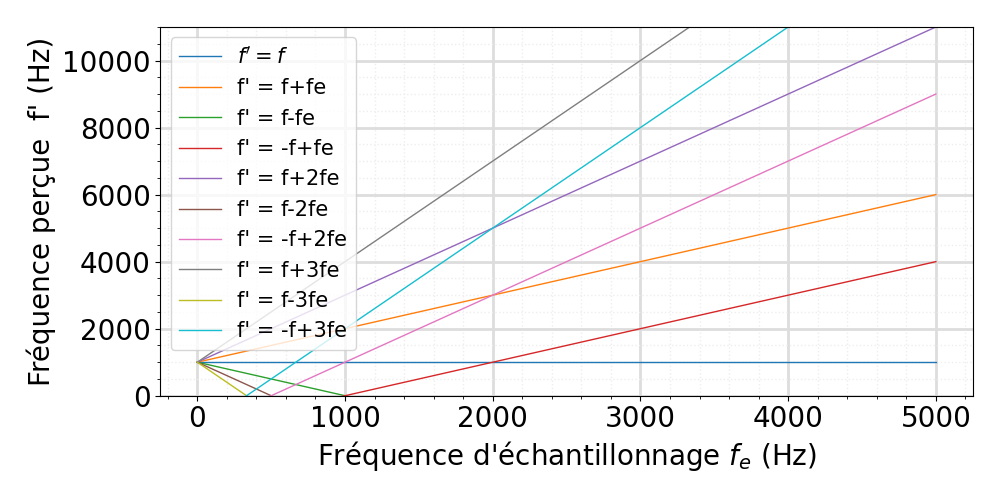

In [6]:
fig,ax = plt.subplots(figsize=(10,5))



ax.set_ylabel(r"Fréquence perçue  f' (Hz)",fontsize=20)
ax.set_xlabel(r"Fréquence d'échantillonnage $f_e$ (Hz)",fontsize=20) #on légende les axes
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)




ax.grid(which='major', color='#DDDDDD', linewidth=2)
ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=1)

ax.minorticks_on()
ax.set_axisbelow(True) 



        

f = 1000
fech = np.linspace(0,5000,100)


ax.plot(fech,f*np.ones(np.shape(fech)), linestyle= 'solid',linewidth=1,label = "$f' = f$") #on trace la fréquence clone correspondant au signal analogique


ax.plot(fech,f+1*fech, linestyle= 'solid',linewidth=1,label = r"f' = f+fe") 
#et les 9 premières fréquences clones (on ne trace pas les - - simplement car elles sortent de ce graphique et de la fenêtre d'une TF "normale"
# car sur un oscillo généralement on regarde la TF sur R+
ax.plot(fech,f-1*fech, linestyle= 'solid',linewidth=1,label = r"f' = f-fe")
ax.plot(fech,-f+1*fech, linestyle= 'solid',linewidth=1,label = r"f' = -f+fe")


ax.plot(fech,f+2*fech, linestyle= 'solid',linewidth=1,label = r"f' = f+2fe")
ax.plot(fech,f-2*fech, linestyle= 'solid',linewidth=1,label = r"f' = f-2fe")
ax.plot(fech,-f+2*fech, linestyle= 'solid',linewidth=1,label = r"f' = -f+2fe")

ax.plot(fech,f+3*fech, linestyle= 'solid',linewidth=1,label = r"f' = f+3fe")
ax.plot(fech,f-3*fech, linestyle= 'solid',linewidth=1,label = r"f' = f-3fe")
ax.plot(fech,-f+3*fech, linestyle= 'solid',linewidth=1,label = r"f' = -f+3fe")


ax.set_ylim([0,np.max(f+2*fech[-1])])


ax.legend(loc='upper left', fontsize=15)
plt.tight_layout()

plt.show()



Lorsque $f_e$ est élevée, on voit que les fréquences "clones" sont toutes à beaucoup plus haute fréquence que f. Si on se contente sur le spectre de lire la fréquence la plus faible, on lit bien $f$.

Lorsque $f_e$ est faible, on voit que beaucoup de fréquences clones aparaissent sur le spectre du signal entre 0 et f. Lorsque $f_e$ diminue, le premier pic "clone" à apparaître dans l'intervalle [0;f] apparaît pour $f_e = 2f$. Dès que $f_e < 2f$, si on se contente sur le spectre de lire la fréquence la plus faible, on ne lit plus correctement $f$.

On utilise donc cette observation pour décrire un critère qualitatif, désignant la fréquence d'échantillonnage minimale nécessaire pour échantillonner correctement un signal : 

<div class="alert alert-block alert-danger">
<b>Critère de Shannon :</b> Pour échantillonner correctement un signal de fréquence maximale $f$, la fréquence d'échantillonnage doit valoir au moins $2f_e$.
</div>


<details>
<summary>Cliquer pour un approfondissement sur le critère de Shannon</summary>

En pratique, on peut très bien exploiter la courbe ci-dessus pour "déplier" les clones du spectre. Ces clones se caractérisent par une périodicité structurelle, mathématiquement on peut donc espérer retrouver le spectre initial. 

Le "vrai" critère de Shannon est donc plutôt : 

<div class="alert alert-block alert-info">
<b>"Vrai" critère de Shannon :</b> Pour échantillonner correctement un signal de fréquence maximale $f$, la fréquence d'échantillonnage doit valoir au moins 2 fois la bande passante du signal échantillonné.
</div>



Car alors, la périodicité structurelle est confondue avec un signal sortant de la bande passante et plus aucun algorithme ne peut fournir de solution unique.
</details>

Si ce premier petit calcul n'était pas assez intuitif, on va voir l'effet de la fréquence d'échantillonnage sur un sinus.


In [9]:
print("Entre la valeur que tu souhaites pour la fréquence de ta fonction périodique (en Hertz), puis appuye sur entrée")
freq=float(input())

Entre la valeur que tu souhaites pour la fréquence de votre fonction périodique (en Hertz), puis appuyes sur entrée


 200


In [10]:
plt.rcParams.update({'font.size': 15})
#locale.setlocale(locale.LC_ALL, '')
plt.rcParams['axes.formatter.use_locale'] = False






def f(freq_ech):
    
    fig, axs = plt.subplots(nrows=1, ncols=2,figsize=(12,6))

    xnewsin = np.linspace(0, 1, 300)  #le temps sera une homothétie de x 
    y_smoothsin = np.sin(2*3.1415*xnewsin) #le signal analogique
    
    
    
    
    axs[0].tick_params(axis='both', which='major', labelsize=20)
    axs[0].tick_params(axis='both', which='minor', labelsize=20)
    
    axs[0].grid(which='major', color='#DDDDDD', linewidth=2)
    axs[0].grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=1)
    axs[0].minorticks_on()
    axs[0].set_axisbelow(True) 

    tempplotsin=[(xnewsin[i],y_smoothsin[i])for i in range(len(xnewsin))]    
    nbT = 5 #on va tracer 5 périodes successives du signal pour plus de lisibilité
    coordsubplotsin = [(tempplotsin[k%len(tempplotsin)][0]/freq+k//len(tempplotsin) /freq,tempplotsin[k%len(tempplotsin)][1]) for k in range(nbT*len(tempplotsin))] #et on les joint bout à bout

    
    coordsubechsin=[]
    Naddsin = int(coordsubplotsin[-1][0]//(1/freq_ech))#identifier le nombre d'échantillons à prélever
   
    for i in range(Naddsin+1):
        for k in range(len(coordsubplotsin)):
            if coordsubplotsin[k][0]-i/freq_ech > 0: #dès qu'on passe une période d'échantillonnage, on récupère un échantillon
                indice_xi_sup_0 = k
                break
                
        coordsubechsin.append(coordsubplotsin[indice_xi_sup_0])#on échantillonne
   
    
    #axs[0].scatter([coordsubplot[i][0] for i in range(len(coordsubplot)) if int(coordsubplot[i][0]*freq_ech)%1==0], [coordsubplot[i][1] for i in range(len(coordsubplot)) if int(coordsubplot[i][0]*freq_ech)%1==0], label='Échantillonnage', color='red')
    axs[0].scatter([i[0] for i in coordsubechsin], [i[1] for i in coordsubechsin], label='Signal échantillonné', color='red')
    axs[0].plot([i[0] for i in coordsubplotsin], [i[1] for i in coordsubplotsin], label='Signal réel')
    if freq_ech<2*freq and freq_ech>freq : #on a donc une seule fréquence clone dans l'intervalle
        axs[0].plot([i[0] for i in coordsubplotsin], [np.sin(i[0]*2*3.141*(freq-freq_ech)) for i in coordsubplotsin],linestyle='dotted' ,label='Fréquence clone',alpha=0.5)
    elif freq_ech<2*freq and freq_ech<freq :#on a donc plusieurs fréquences clones, on précise donc en légende
        axs[0].plot([i[0] for i in coordsubplotsin], [np.sin(i[0]*2*3.141*(freq-freq_ech)) for i in coordsubplotsin],linestyle='dotted' ,label='Une des fréquences clones',alpha=0.5)
    
    axs[0].legend(loc = 'upper right',fontsize=20)
    axs[0].set_ylabel("Amplitude (U.A.)",fontsize=20)
    axs[0].set_xlabel("Temps (s)")
    axs[0].set_title("Enregistrement")

 #-------------------------------------------------------------------------------
    #le spectre :

    nbTsin = 100 #pour avoir un joli spectre, on le fait sur 100x ce qu'on affiche à gauche.
    TFmashupsin=[(xnewsin[i],y_smoothsin[i]) for i in range(len(xnewsin))]
    coordfouriersin = [(TFmashupsin[k%len(TFmashupsin)][0]/freq+k//len(TFmashupsin) /freq,TFmashupsin[k%len(TFmashupsin)][1]) for k in range(nbTsin *len(TFmashupsin))]
    pointssin = coordfouriersin
    
    Tsin = xnewsin[-1]/(freq*len(xnewsin))  #Durée entre deux échantillons successifs, utile pour avoir une échelle de fréquence sur la TF
    
    xsin = np.array([xh for xh, _ in pointssin])
    ysin = np.array([yh for _, yh in pointssin])
    yfsin = fft(ysin)#on calcule la tf
    xfsin = fftfreq(len(pointssin), Tsin) #on obtient une échelle de fréquences en abscisse
    xfsin = fftshift(xfsin)
    yplotsin = fftshift(yfsin)#on centre cette tf
    axs[1].plot(xfsin, 1.0 / len(pointssin) * np.abs(yplotsin),alpha=0.5,label="spectre signal initial")#et on la trace
    axs[1].set_xlim([0,2*freq])#on ne plot pas trop loin pour une meilleure visibilité


    nbT = 100
    TFmashupsin=[(xnewsin[i],y_smoothsin[i]) for i in range(len(xnewsin))] #à nouveau, pour une belle TF on colle bout à bout 100 fois ce qu'on affiche

    
    coordfouriersin = [(TFmashupsin[k%len(TFmashupsin)][0]/freq+k//len(TFmashupsin) /freq,TFmashupsin[k%len(TFmashupsin)][1]) for k in range(nbT *len(TFmashupsin))]
    #time = np.linspace(0,nbT/freq,len(coordplot))
    
    coordsubech2sin=[]
    Nadd2sin = int(coordfouriersin[-1][0]//(1/freq_ech))#le nombre d'échantillons à prélever
   
    for i in range(Nadd2sin):
        coordsubech2sin.append(coordfouriersin[int((i)*len(coordfouriersin)/Nadd2sin)])# on prélève ces échantillons
    
    points2sin = coordsubech2sin
    

    T2=1/freq_ech #la dufée entre 2 pts échantillonnés, pour avoir l'axe des abscisses en fréquence par la suite.
    
    x2sin = np.array([xi for xi, _ in points2sin])
    y2sin = np.array([yi for _, yi in points2sin])
    
    
    yf2sin = fft(y2sin)#on en prend la TF
    xf2sin = fftfreq(len(points2sin), T2)#l'axe des abscisses en fréquence
    #print(np.max(xf2sin))
    xf2sin = fftshift(xf2sin) 
    #print(np.max(xf2sin))
    yplot2sin = fftshift(yf2sin)
    #naturellement, la TF numérique s'arrête au critère de Shannon, pour montrer ce que verrait un oscillo , on pourrait dupliquer xf2sin et yplot2sin
    
    axs[1].plot(xf2sin, 1.0 / len(points2sin) * np.abs(yplot2sin),alpha=0.5,label="spectre signal échantillonné")
    axs[1].set_xlim([0,2*freq])
    
    #axs[1].set_xlim((0,1200))





    axs[1].set_ylabel("Amplitude (U.A.)")
    axs[1].set_xlabel("Fréquence (Hz)")
    #axs[0, 0].set_title("Enregistrement d'une onde sonore de fréquence f = {} Hz".format(round(freq,1)))
    axs[1].set_title("Spectre")
    #itx = np.fft.ifft(tx);
    axs[1].grid(which='major', color='#DDDDDD', linewidth=3)

    axs[1].grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=1.5)

    axs[1].minorticks_on()

    plt.legend(loc = 'upper right')
    plt.show()

    return 

#actualisation de la barre d'actualisation dynamique
interactive_plot = interact(f, freq_ech=(int(freq/7), int(freq/7)*7*6,int(freq/7)))

interactive(children=(IntSlider(value=588, description='freq_ech', max=1176, min=28, step=28), Output()), _dom…

Lorsque $f_e<2f$ on voit que le spectre échantillonné n'est plus fidèle au spectre réel du signal initial !

Pour approfondir une dernière fois la notion, on peut regarder l'effet de l'échantillonnage sur un signal périodique quelconque. 

**Rappel :** Pour un signal périodique quelconque, son spectre est constitué de multiples de sa fréquence fondamentale.

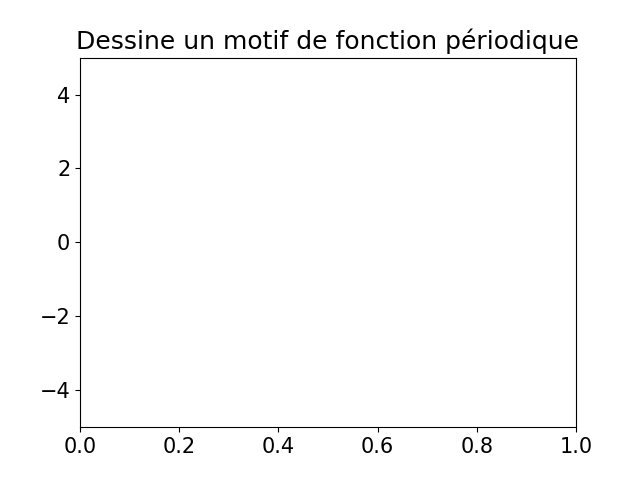

In [13]:


# Create a figure and axis
fig, ax = plt.subplots()
ax.set_title('Dessine un motif de fonction périodique')
ax.set_xlim(0, 1)
ax.set_ylim(-5, 5)

#liste des coordonnées utilisateur
coords = []

# Fonction lasso pour enregistrer les input de l'user
def onselect(verts):
    path = Path(verts)
    coords.extend(verts)
    ax.plot(*zip(*verts), marker='o', color='r')
    fig.canvas.draw()

lasso = LassoSelector(ax, onselect)

plt.show()



In [14]:
print("Entre la valeur que tu souhaites pour la fréquence (en Hertz) de ta fonction périodique, puis appuye sur entrée")
freq=float(input())

Entre la valeur que tu souhaites pour la fréquence (en Hertz) de votre fonction périodique, puis appuyez sur entrée


 200


Puis on va interpoler ce motif, le "lisser" histoire qu'il aie de meilleures propriétés mathématiques.

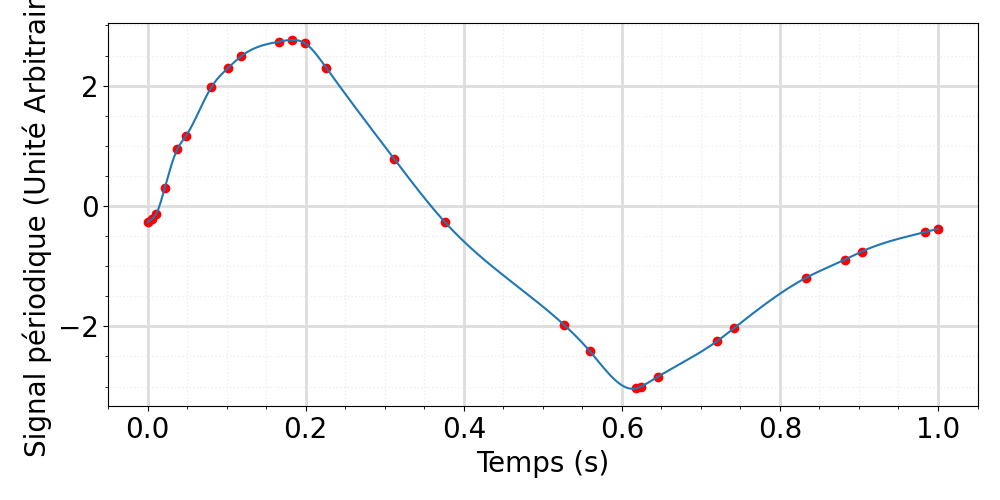

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline



valeur_min_xi = min(coords, key=lambda t: t[0])
valeur_max_xi = max(coords, key=lambda t: t[0])
# Trouve l'indice i du minimum des xi
indice_min_xi = coords.index(valeur_min_xi)
indice_max_xi = coords.index(valeur_max_xi)


coords = sorted(coords, key=lambda couple: couple[0])


coords = [((i[0]-valeur_min_xi[0])/(valeur_max_xi[0]-valeur_min_xi[0]),i[1]) for i in coords] 
#bijection de xmin xmax vers 0,1 et (bouclage continu de ymin ymax ) --> moins intuitif possiblement lorsqu'on découvre la notion
#on laisse donc la discontinuité entre 0- et 0+

data = coords
x, y = zip(*data)  

# On enlève les duplicata en x pour pouvoir définir une fonction de x
unique_x, unique_y = [], []
for xi, yi in zip(x, y):
    if xi not in unique_x:
        unique_x.append(xi)
        unique_y.append(yi)


xnew = np.linspace(min(unique_x), max(unique_x), 300) 
spl = make_interp_spline(unique_x, unique_y, k=3)  # Interpolation spline cubique (ce que j'ai trouvé de plus stable)
y_smooth = spl(xnew)




fig,ax = plt.subplots(figsize=(10,5))



ax.set_xlabel(r"Temps (s)",fontsize=20)
ax.set_ylabel(r"Signal périodique (Unité Arbitraire)",fontsize=20) #on légende
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)




ax.grid(which='major', color='#DDDDDD', linewidth=2)
ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=1)
ax.minorticks_on()
ax.set_axisbelow(True) 



        
nbT = 4
coordplot = [(coords[k%len(coords)][0]/freq+k//len(coords) /freq,coords[k%len(coords)][1]) for k in range(4*len(coords))] 
#on met bout à bout 4 périodes (pour la suite)


ax.scatter(unique_x, unique_y, label='Original data', color='red') #et on trace déjà l'interpolation
ax.plot(xnew, y_smooth, label='Spline Interpolation')


plt.tight_layout()

plt.show()





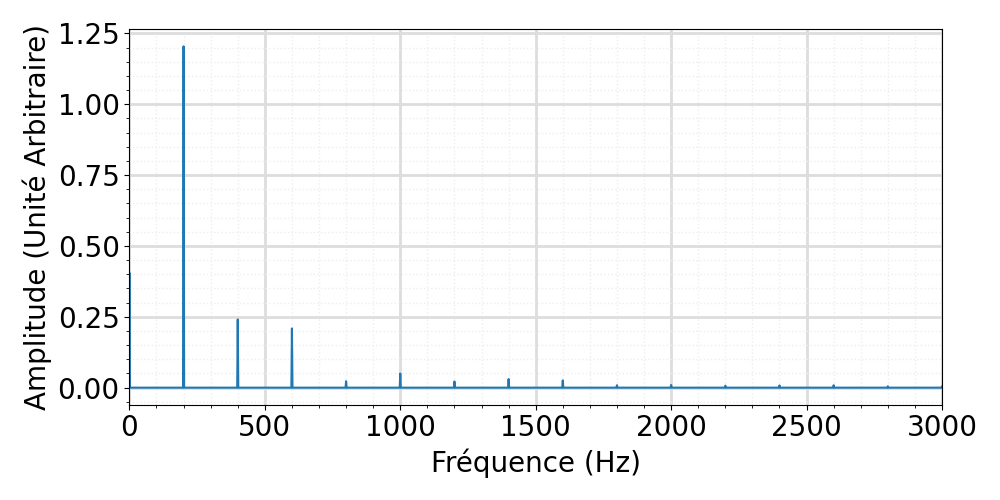

In [16]:
from scipy.fft import fft, fftfreq, fftshift
import numpy as np

# Maintenant on va mettre vout à bout 100 itérations du motif périodique, et en prendre la TF

nbT = 100
TFmashup=[(xnew[i],y_smooth[i]) for i in range(len(xnew))]
coordfourier = [(TFmashup[k%len(TFmashup)][0]/freq+k//len(TFmashup) /freq,TFmashup[k%len(TFmashup)][1]) for k in range(nbT *len(TFmashup))]
points = coordfourier


T = xnew[-1]/(freq*len(xnew))  # comme précédemment, pour avoir l'axe des fréquences correctement défini

x = np.array([x for x, _ in points])
y = np.array([y for _, y in points])

yf = fft(y)
xf = fftfreq(len(points), T)
xf = fftshift(xf)
yplot = fftshift(yf)



fig,ax = plt.subplots(figsize=(10,5))


ax.set_xlabel(r"Fréquence (Hz)",fontsize=20)
ax.set_ylabel(r"Amplitude (Unité Arbitraire)",fontsize=20)#on légende
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)


ax.grid(which='major', color='#DDDDDD', linewidth=2)

ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=1)

ax.minorticks_on()
ax.set_axisbelow(True) 


ax.plot(xf, 1.0 / len(points) * np.abs(yplot))


ax.set_xlim([0,15*freq])


plt.tight_layout()

plt.show()


In [17]:
plt.rcParams.update({'font.size': 15})
plt.rcParams['axes.formatter.use_locale'] = False

#compilation des code snippet précédents, dans l'esprit

def f(freq_ech):
    
    fig, axs = plt.subplots(nrows=1, ncols=2,figsize=(12,6))

    xnew = np.linspace(min(unique_x), max(unique_x), 300) #on génère les valeurs x pour l'abscisse
    spl = make_interp_spline(unique_x, unique_y, k=3)  # On reprend l'interpolation précédente
    y_smooth = spl(xnew)
    
    
    
    axs[0].set_xlabel(r"Temps (s)",fontsize=20)
    axs[0].set_ylabel(r"Signal périodique (Unité Arbitraire)",fontsize=20)#on légende
    axs[0].tick_params(axis='both', which='major', labelsize=20)
    axs[0].tick_params(axis='both', which='minor', labelsize=20)
    
    axs[0].grid(which='major', color='#DDDDDD', linewidth=2)
    axs[0].grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=1)

    axs[0].minorticks_on()
    axs[0].set_axisbelow(True) 


    #on affiche 4 périodes successives à l'utilisateur dans la partie enregistrement
    tempplot=[(xnew[i],y_smooth[i])for i in range(len(xnew))]    
    nbT = 4
    coordsubplot = [(tempplot[k%len(tempplot)][0]/freq+k//len(tempplot) /freq,tempplot[k%len(tempplot)][1]) for k in range(nbT*len(tempplot))]

    coordsubech=[]
    Nadd = int(coordsubplot[-1][0]//(1/freq_ech))
   
    for i in range(Nadd):
        for k in range(len(coordsubplot)):
            if coordsubplot[k][0]-i/freq_ech > 0:
                indice_xi_sup_0 = k
                break
        coordsubech.append(coordsubplot[indice_xi_sup_0]) #on échantillonne 
    

    ##########################
    
    #axs[0].scatter([coordsubplot[i][0] for i in range(len(coordsubplot)) if int(coordsubplot[i][0]*freq_ech)%1==0], [coordsubplot[i][1] for i in range(len(coordsubplot)) if int(coordsubplot[i][0]*freq_ech)%1==0], label='Échantillonnage', color='red')
    axs[0].scatter([i[0] for i in coordsubech], [i[1] for i in coordsubech], label='Signal échantillonné', color='red')#tracé du signal échantillonné
    axs[0].plot([i[0] for i in coordsubplot], [i[1] for i in coordsubplot], label='Signal réel') #tracé du signal initial
    axs[0].legend(loc = 'upper right')
   
    

    axs[0].set_ylabel("Amplitude (U.A.)")
    axs[0].set_xlabel("Temps (s)")
    axs[0].set_title("Enregistrement")



    #--------------------------------------------------------
    #la tf : 

    #on met bout à bout 100 périodes pour une jolie TF
    
    nbT = 100
    TFmashup=[(xnew[i],y_smooth[i]) for i in range(len(xnew))]
    coordfourier = [(TFmashup[k%len(TFmashup)][0]/freq+k//len(TFmashup) /freq,TFmashup[k%len(TFmashup)][1]) for k in range(nbT *len(TFmashup))]
    points = coordfourier
    

    T = xnew[-1]/(freq*len(xnew))  #pour l'abscisse en fréquence...
    
    x = np.array([x for x, _ in points])
    y = np.array([y for _, y in points])
    
    yf = fft(y)
    xf = fftfreq(len(points), T)
    xf = fftshift(xf)
    yplot = fftshift(yf)
    axs[1].plot(xf, 1.0 / len(points) * np.abs(yplot),alpha=0.5,label="spectre signal initial")
    axs[1].set_xlim([0,15*freq])


    nbT = 100 #même chose pour le signal échantillonné maintenant
    TFmashup=[(xnew[i],y_smooth[i]) for i in range(len(xnew))]

    
    
    coordfourier = [(TFmashup[k%len(TFmashup)][0]/freq+k//len(TFmashup) /freq,TFmashup[k%len(TFmashup)][1]) for k in range(nbT *len(TFmashup))]

    
    coordsubech2=[]
    Nadd2 = int(coordfourier[-1][0]//(1/freq_ech))
   
    for i in range(Nadd2):
        for k in range(max([0,int((i-0.5)*len(coordfourier)/Nadd2)]),len(coordfourier)):
            if coordfourier[k][0]-i/freq_ech > 0:
                indice_xi_sup_0 = k
                break
        coordsubech2.append(coordfourier[indice_xi_sup_0])

    
    points2 = coordsubech2
    

    T2 = 1/freq_ech  # pour le signal échantillonné
    
    x2 = np.array([xi for xi, _ in points2])
    y2 = np.array([yi for _, yi in points2])
    
    yf2 = fft(y2)
    xf2 = fftfreq(len(points2), T2)
    xf2 = fftshift(xf2)
    yplot2 = fftshift(yf2)
    axs[1].plot(xf2, 1.0 / len(points2) * np.abs(yplot2),alpha=0.5,label="spectre signal échantillonné")
    axs[1].set_xlim([0,15*freq])


    axs[1].set_ylabel("Amplitude (U.A.)")
    axs[1].set_xlabel("Fréquence (Hz)")#on légende
    axs[1].set_title("Spectre")

    axs[1].grid(which='major', color='#DDDDDD', linewidth=3)
    axs[1].grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=1.5)

    axs[1].minorticks_on()

    plt.legend(loc = 'upper right')
    plt.show()

    return 

#actualisation de la barre d'actualisation dynamique
interactive_plot = interact(f, freq_ech=(int(freq/4), int(freq/4)*100,int(freq/4)))

interactive(children=(IntSlider(value=2500, description='freq_ech', max=5000, min=50, step=50), Output()), _do…

On remarque que le spectre du signal échantillonné commence à se distinguer du spectre du signal initial à des fréquences d'échantillonnages bien plus élevées que le double de la fréquence fondamentale. À ton avis, la fréquence fondamentale est-elle si pertinente ici pour définir la fréquence d'échantillonnage minimale?

 <details><summary>Réponse :</summary> Lorsque $f_e$ diminue, les premières fréquences à ne plus respecter le critère de Shannon sont bien sûr les plus élevées, c'est donc leurs pics qui sont les premiers affectés. Pour garantir un joli spectre, il faut s'assurer que la fréquence <b>maximale</b> du signal respecte le critère de Shannon. Juste en-dessous de la définition du critère de Shannon, un petit approfondissement va même encore un peu plus loin à ce sujet.</details></details>

***

### I.4- Acquisition d'un signal

Cela nous emmène à notre dernière considération d'importance : Si on a un signal donné, dont on veut obtenir le spectre (par exemple un oscillateur dont on veut mesurer la fréquence d'oscillation), quels paramètres d'acquisition seront les plus pertinents? On va tâcher d'y répondre.

**Jusqu'à maintenant, par confort de lecture, la TF n'était pas calculée exactement sur l'enregistrement de gauche qui était affiché.** On va maintenant observer le signal temporel tel quel, ainsi que sa TF, quitte à devoir zoomer sur les graphiques.

In [18]:
plt.rcParams.update({'font.size': 15})
#locale.setlocale(locale.LC_ALL, '')
plt.rcParams['axes.formatter.use_locale'] = False



list_types=['sinus','créneau','impulsion dirac périodique','impulsion dirac seule']

def makesignal(typ,freq,ampl,time):
    if typ=='sinus':
        return(ampl*np.sin(2*np.pi*freq*time))
    elif typ=='créneau':
        return(ampl*np.sign(np.sin(2*np.pi*freq*time)))
    elif typ=='impulsion dirac périodique':
        sign=np.zeros(np.shape(time))
        indexdirac=[]
        for k in range(len(time)):
            if time[k]*freq > len(indexdirac): #dès qu'on passe une période d'échantillonnage, on récupère un dirac
                indexdirac.append(k)
                #break
        for makedir in indexdirac :
            sign[makedir]=ampl
        return(sign)
    elif typ == 'impulsion dirac seule':
        sign=np.zeros(np.shape(time))
        sign[1]= ampl#*len(time)/(2*np.pi)
        return(sign)
    else :
        return(np.zeros(np.shape(time)))


def f(type_signal, amplitude,frequence,duree,freq_echant):
    
    fig, axs = plt.subplots(nrows=1, ncols=2,figsize=(12,6))
    #duree en milliseconde en entrée
    xnewsin = np.linspace(0, duree*1e-3, int(duree*1e-3*freq_echant))  #le temps sera une homothétie de x 
    signaltot=makesignal(type_signal,frequence,amplitude,xnewsin)

    

    
    
    axs[0].tick_params(axis='both', which='major', labelsize=20)
    axs[0].tick_params(axis='both', which='minor', labelsize=20)
    
    axs[0].grid(which='major', color='#DDDDDD', linewidth=2)
    axs[0].grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=1)
    axs[0].minorticks_on()
    axs[0].set_axisbelow(True) 


    
    axs[0].plot( xnewsin*1e3,signaltot, label='Signal créé')
       
    axs[0].legend(loc = 'upper right',fontsize=20)
    axs[0].set_ylabel("Amplitude (U.A.)",fontsize=20)
    axs[0].set_xlabel("Temps (ms)")
    axs[0].set_title("Enregistrement")

 #-------------------------------------------------------------------------------
    #le spectre :


    TFmashupsin=[(xnewsin[i],signaltot[i]) for i in range(len(xnewsin))]
    #coordfouriersin = [(TFmashupsin[k%len(TFmashupsin)][0]+(k//len(TFmashupsin))*TFmashupsin[-1][0],TFmashupsin[k%len(TFmashupsin)][1]) for k in range(nbTsin *len(TFmashupsin))]
    pointssin = TFmashupsin#coordfouriersin
    
    
    Tsin = xnewsin[-1]/(len(xnewsin))  #Durée entre deux échantillons successifs, utile pour avoir une échelle de fréquence sur la TF

    
    xsin = np.array([xh for xh, _ in pointssin])
    ysin = np.array([yh for _, yh in pointssin])
    yfsin = fft(ysin)#on calcule la tf
    xfsin = fftfreq(len(pointssin), Tsin) #on obtient une échelle de fréquences en abscisse
    xfsin = fftshift(xfsin)
    yplotsin = fftshift(yfsin)#on centre cette tf
    axs[1].plot(xfsin, 1.0 / len(pointssin) * np.abs(yplotsin),alpha=1,label="spectre signal initial")#et on la trace
    axs[1].set_xlim(left=0)#on ne plot pas trop loin pour une meilleure visibilité
    #axs[1].set_ylim(bottom=-0.05)

    axs[1].set_ylabel("Amplitude (U.A.)")
    axs[1].set_xlabel("Fréquence (Hz)")
    #axs[0, 0].set_title("Enregistrement d'une onde sonore de fréquence f = {} Hz".format(round(freq,1)))
    axs[1].set_title("Spectre")
    #itx = np.fft.ifft(tx);
    axs[1].grid(which='major', color='#DDDDDD', linewidth=3)

    axs[1].grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=1.5)

    axs[1].minorticks_on()

    plt.legend(loc = 'upper right')
    plt.show()

    return 

#actualisation de la barre d'actualisation dynamique
interactive_plot = interact(f, type_signal=list_types, amplitude=(-5, 5,1),frequence=(100, 2000,100),duree=(1,1000,1),freq_echant=(3000, 300000,10000))

interactive(children=(Dropdown(description='type_signal', options=('sinus', 'créneau', 'impulsion dirac périod…

On va voir si modifier la durée d'acquisition $\tau$ modifie le spectre. Pour quantifier cet effet, prenons par exemple un signal créneau de fréquence et d'amplitude quelconque.

Une grandeur clé dans la qualité d'un spectre est la distance en fréquence entre deux points successifs du spectre. Plus cette distance est faible, meilleure est la résolution du spectre.

**Par lecture graphique du tracé interactif ci-dessus, éditer la cellule ci-dessous pour relier l'écart entre deux points successifs du spectre $\Delta f$ en fonction de la durée d'acquisition $\tau$. Entre 5 et 10 couples de valeurs ($\tau$,$\Delta f$) suffisent.** 

> On peut zoomer autour du pic du spectre afin de bien bien voir l'écart en fréquence entre deux points successifs du spectre.
> <details><summary>Pour zommer sur un graphique (cliquer ici pour voir comment)</summary> <img src="tuto_e.gif" width="600" align="center"> </details></details>


In [ ]:
#compléter les deux listes ci-dessous par les valeurs que tu obtiens :

liste_tau=[] #ne pas oublier de convertir les ms en secondes
liste_delta_f =[] 



fig,ax = plt.subplots(figsize=(10,5))

ax.set_xlabel(r"$\frac{1}{\tau}$ (Hz)",fontsize=20)
ax.set_ylabel(r"$\Delta f$ (Hz)",fontsize=20) #on légende
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)
ax.grid(which='major', color='#DDDDDD', linewidth=2)
ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=1)
ax.minorticks_on()
ax.set_axisbelow(True) 

ax.plot(1/np.asarray(liste_tau), liste_delta_f, label=r'$\Delta f(\frac {1} {\tau})$')
ax.scatter(1/np.asarray(liste_tau), liste_delta_f,color='r')

plt.tight_layout()
plt.legend()

plt.show()


**Note :** On a tracé $\Delta f$ en fonction de $\frac 1 \tau $ afin que les unités soient identiques et la relation entre les deux grandeurs plus facile à identifier.

<div class="alert alert-block alert-warning">
<b>Important:</b> La pente de la courbe précédente a quelque chose de remarquable !
</div>

**Qu'en déduit-on quant à la relation entre la durée $\tau$ d'une acquisition et la distance $\Delta f$ entre les points successifs du spectre?**

***


<div class="alert alert-block alert-success">
<b>Lien entre durée d'une acquisition et résolution de la TF :</b> Si la durée d'acquisition $\tau$ augmente alors la distance $\Delta f$ entre deux points successifs du spectre diminue. On a concrètement $\Delta f \times \tau = 1$.
</div>

De façon quasiment réciproque, on a également vu que si la fréquence d'échantillonnage $f_e$ augmente alors la fréquence maximale du spectre augmente (Shannon).

> **Remarque :**
> 
> Autrement dit :
> * augmenter la **longueur totale** temporelle améliore la *résolution* du spectre
> * augmenter la *résolution* temporelle augmente la **longueur totale** du spectre.


✅ Tu peux maintenant traiter l'application "Optimiser son acquisition"

***


Pour élargir ta culture, voici deux sujets connexes, à approfondir selon tes envies :

* La mémoire des premières consoles de jeu-vidéo était si limitée qu'il était impossible d'y enregistrer la musique du jeu. Par exemple, une cartouche de NES a une mémoire d'environ 1,6 Mb, alors que le seul fichier mp3 du thème principal de Contra, sur NES, pèse déjà 32,8 Mb! Les équipes de développement ont donc longtemps dû ruser, ce qui est expliqué dans cet extrait de vidéo de Joueur du Grenier : https://podeduc.apps.education.fr/video/39253-les-musiques-de-jeux-video-comment-ca-fonctionne-bazar-du-grenier-extrait/,
* Les premières générations de jeux vidéos étaient classées selon leur nombre de bits de quantification. Sur une console 8 bits, une couleur devait *(usuellement)* être codée avec uniquement 8 bits, par exemple 01101011. La couleur était donc elle aussi quantifiée (et l'est toujours), ce qui limite la palette utilisable ! Pour plus d'informations : https://en.wikipedia.org/wiki/8-bit_color
* On peut également étudier le spectre spatial d'un objet, lié à ses périodicités spatiales. Un exercice bonus de la feuille d'exercice y est dédié.